In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_path = '/content/drive/My Drive/Food Classification/'

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

image_dir = Path(image_path)
filepaths = list(image_dir.glob('**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [5]:
images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(130, random_state=1))

image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [7]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

validation_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1456 validated image filenames belonging to 20 classes.
Found 363 validated image filenames belonging to 20 classes.
Found 781 validated image filenames belonging to 20 classes.


In [9]:
pretrained_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

pretrained_model.trainable = False

x = pretrained_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to flatten feature maps
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(20, activation='softmax')(x)  # Adjust for the number of classes

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
model = Model(inputs=pretrained_model.input, outputs=outputs)

print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,084,148 (84.24 MB)

 Trainable params: 281,364 (1.07 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

None


In [11]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            mode='min'
        )
    ]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 589s 11s/step - accuracy: 0.2271 - loss: 2.6461 - val_accuracy: 0.4848 - val_loss: 1.6937
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 243s 5s/step - accuracy: 0.6021 - loss: 1.3451 - val_accuracy: 0.5978 - val_loss: 1.3163
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 277s 6s/step - accuracy: 0.7535 - loss: 0.8697 - val_accuracy: 0.7052 - val_loss: 0.9704
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.8359 - loss: 0.5852 - val_accuracy: 0.7218 - val_loss: 0.9392
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.8770 - loss: 0.4613 - val_accuracy: 0.7107 - val_loss: 0.9821
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.8903 - loss: 0.3666 - val_accuracy: 0.7493 - val_loss: 0.9835
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - accuracy: 0.9572 - loss: 0.2183 - val_accuracy: 0.7300 - val_loss: 0.9531


In [12]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 71.70%


In [13]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step


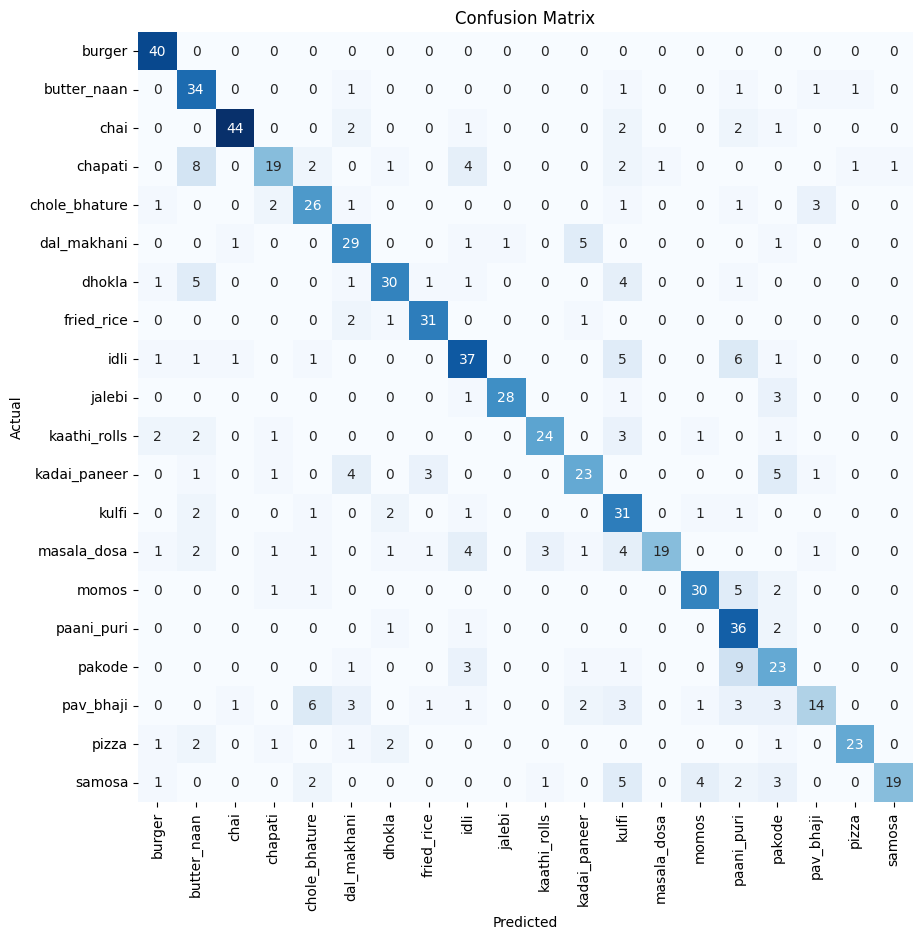

In [14]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

       burger       0.83      1.00      0.91        40
  butter_naan       0.60      0.87      0.71        39
         chai       0.94      0.85      0.89        52
      chapati       0.73      0.49      0.58        39
chole_bhature       0.65      0.74      0.69        35
  dal_makhani       0.64      0.76      0.70        38
       dhokla       0.79      0.68      0.73        44
   fried_rice       0.84      0.89      0.86        35
         idli       0.67      0.70      0.69        53
       jalebi       0.97      0.85      0.90        33
 kaathi_rolls       0.86      0.71      0.77        34
 kadai_paneer       0.70      0.61      0.65        38
        kulfi       0.49      0.79      0.61        39
  masala_dosa       0.95      0.49      0.64        39
        momos       0.81      0.77      0.79        39
   paani_puri       0.54      0.90      0.67        40
       pakode    

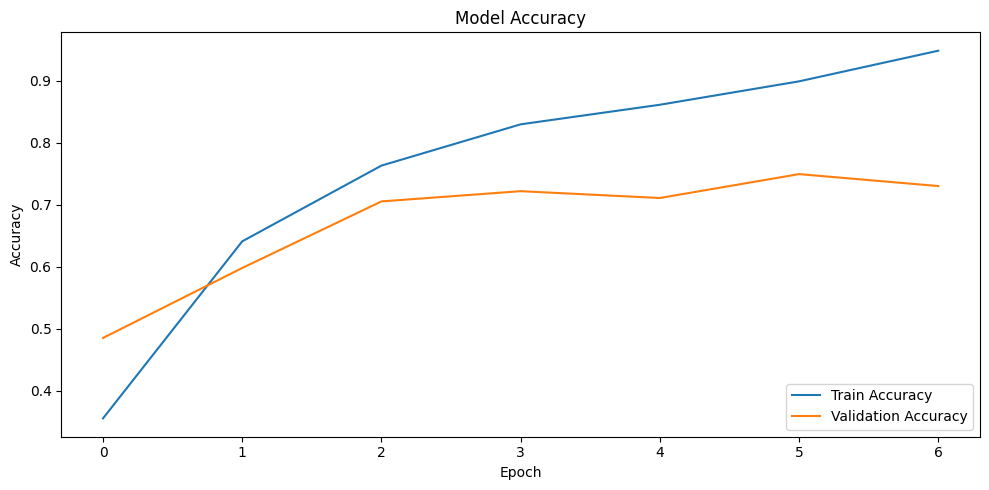

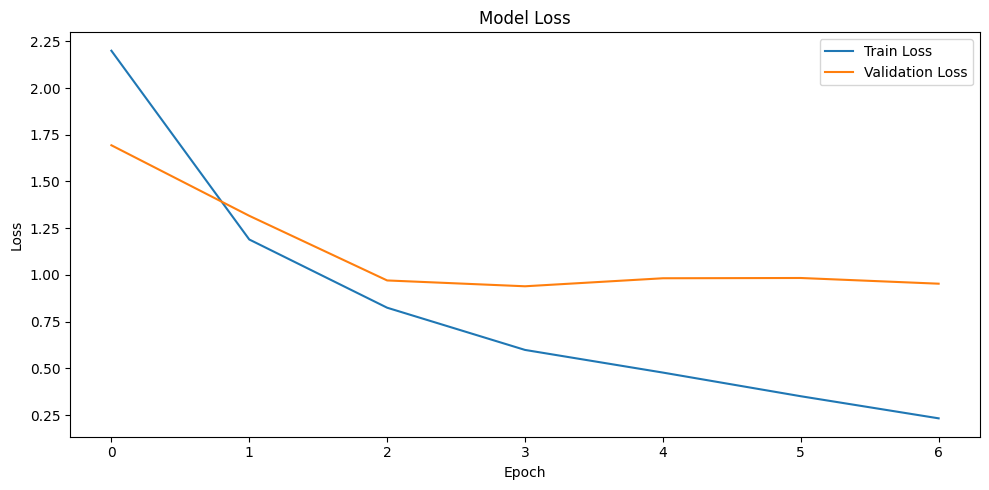

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
if 'fine_tune_history' in locals():  # Check if fine_tune_history exists
    plt.plot(np.arange(len(history.history['accuracy']), len(history.history['accuracy']) + len(fine_tune_history.history['accuracy'])),
             fine_tune_history.history['accuracy'], label='Fine-tune Train Accuracy')
    plt.plot(np.arange(len(history.history['val_accuracy']), len(history.history['val_accuracy']) + len(fine_tune_history.history['val_accuracy'])),
             fine_tune_history.history['val_accuracy'], label='Fine-tune Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
if 'fine_tune_history' in locals():  # Check if fine_tune_history exists
    plt.plot(np.arange(len(history.history['loss']), len(history.history['loss']) + len(fine_tune_history.history['loss'])),
             fine_tune_history.history['loss'], label='Fine-tune Train Loss')
    plt.plot(np.arange(len(history.history['val_loss']), len(history.history['val_loss']) + len(fine_tune_history.history['val_loss'])),
             fine_tune_history.history['val_loss'], label='Fine-tune Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

